In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import jcopdl
from torch import nn, optim
from jcopdl.callback import Callback, set_config


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [5]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)


In [6]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur dan config

In [7]:
from torchvision.models import mobilenet_v2

In [8]:
mnet = mobilenet_v2(pretrained=True)
for param in mnet.parameters():
    param.requires_grad = False
    
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [9]:
# arsitektur yg sudah ditimpa
mnet

In [10]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True
            

In [11]:
config = set_config({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Phase 1 : Adaptation (lr standard + patient kecil)

In [12]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")


In [13]:
from tqdm.auto import tqdm


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 0.5093 | Test_cost  = 0.3928 | 




Epoch     2
Train_cost  = 0.3601 | Test_cost  = 0.3157 | 




Epoch     3
Train_cost  = 0.3111 | Test_cost  = 0.2930 | 




Epoch     4
Train_cost  = 0.2708 | Test_cost  = 0.2625 | 




Epoch     5
Train_cost  = 0.2624 | Test_cost  = 0.2465 | 




Epoch     6
Train_cost  = 0.2605 | Test_cost  = 0.2455 | 




Epoch     7
Train_cost  = 0.2409 | Test_cost  = 0.2329 | 




Epoch     8
Train_cost  = 0.2290 | Test_cost  = 0.2334 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2329




Epoch     9
Train_cost  = 0.2210 | Test_cost  = 0.2345 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2329
==> Execute Early Stopping at epoch: 9 | Best test_cost: 0.2329
==> Best model is saved at model


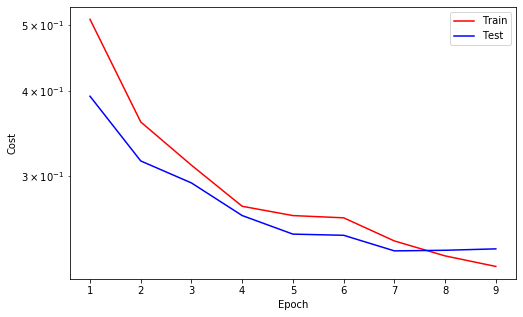

In [14]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    # checkpoint
    callback.save_checkpoint()
    
    # Runtime plotting
    callback.cost_runtime_plotting()
    
    # Early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break
        

# Phase 2 : fine-tuning (lr dikecilin, patience ditambah)

In [15]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)


callback.reset_early_stop() 
callback.early_stop_patience = 5 

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    # checkpoint
    callback.save_checkpoint()
    
    # Runtime plotting
    callback.cost_runtime_plotting()
    
    # Early stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        break
        

# Predict

In [14]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval() 
    output = model(feature) 
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0

# Sanity check

In [15]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [16]:
import matplotlib.pyplot as plt

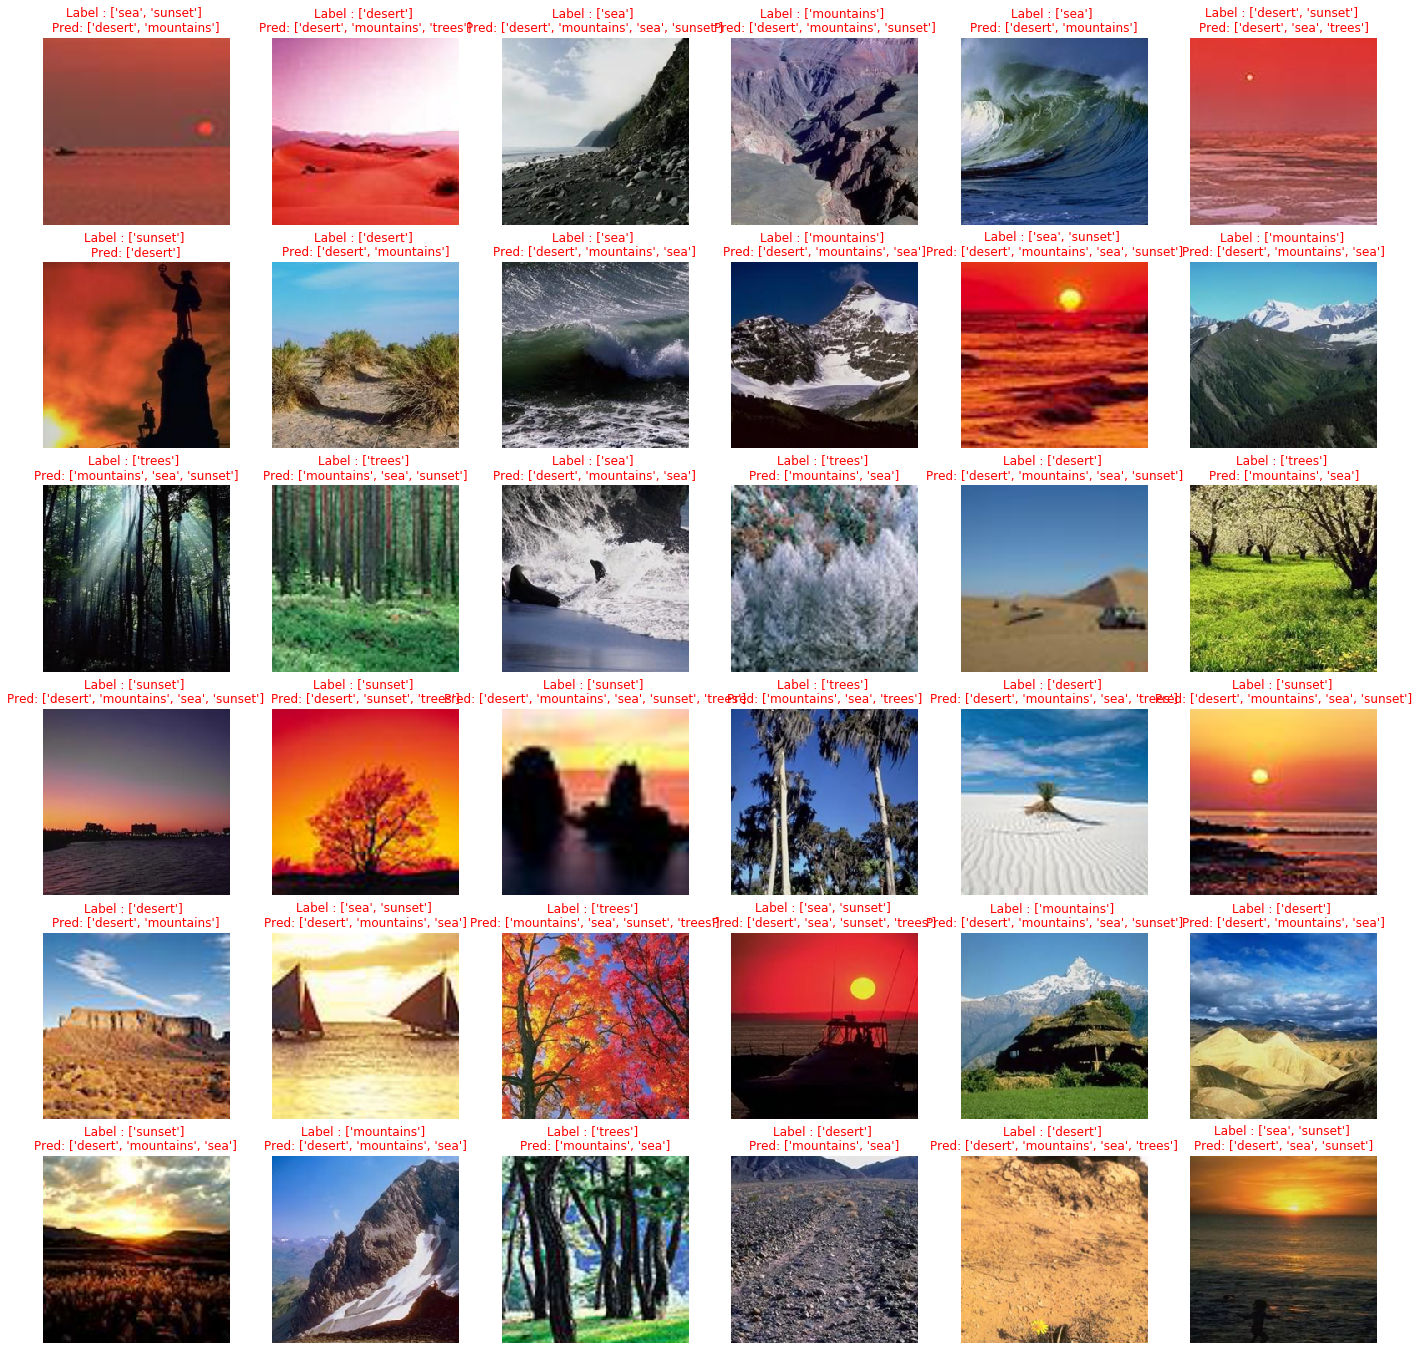

In [17]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color" : 'r'} if (pred != label).any() else {"color" : 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label : {label} \nPred: {pred}", fontdict=font);
    ax.axis('off');
    